# Calculate MSDs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("poster")
plEKW = {'lw':2, 'alpha':0.7}
erEKW = {'fmt':'.-', 'lw':2, 'capsize':2, 'capthick':2, 'elinewidth':2, 'alpha':0.7}

In [2]:
import MDAnalysis as mdan
from MDAnalysis.analysis import rdf as mAnRDF
from MDAnalysis.analysis import distances as mAnDist
import networkx as nx
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")

In [3]:
def Read_N130_Trajectory(top_file, trj_file, num_of_reps=108, verbose=False):
    dum_universe = mdan.Universe(top_file, trj_file, format="LAMMPS")
    if verbose:
        print("The simulation box is", dum_universe.dimensions[:3])
    #Adding the names of the molecules
    names_of_res = ['N130']
    [names_of_res.append('rpL5') for i in range(15)]
    names_of_res = names_of_res*num_of_reps
    dum_universe.add_TopologyAttr(topologyattr='resnames', values=names_of_res)
    
    #Getting the lengths of the different molecules (or bits) we care about
    n130_len = len(dum_universe.residues[0].atoms)
    pept_len = len(dum_universe.residues[1].atoms)
    n130_arm_len = int((n130_len - 1)/5)
    mol_lens = [n130_len, n130_arm_len, pept_len]
    if verbose:
        print("N130 has {:} beads; each arm has {:} beads.".format(n130_len, n130_arm_len))
        print("The peptide has {:} beads.".format(pept_len))
    pept_num = int(len(dum_universe.select_atoms('resname rpL5'))/pept_len)
    n130_num = 108
    mol_nums = [n130_num, pept_num]
    return [dum_universe, mol_lens, mol_nums]

In [4]:
# Run this for each replica
dum_dat = f'lk_8_init.data'
dum_trj = f'lk_8_example_traj.dcd'
dum_un, dum_lens, dum_nums  = Read_N130_Trajectory(dum_dat, dum_trj, 108, True)

The simulation box is [338.10733 338.10733 338.10733]
N130 has 211 beads; each arm has 42 beads.
The peptide has 17 beads.


/home/research/furqan.dar/.conda/envs/darPython/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [5]:
#Only the charged residues from each block

A0_LIST = [6, 7, 10, 12, 17]
A1_LIST = [20, 22, 24, 25, 27]
A2_LIST = [33, 34, 35, 37, 39, 40, 41, 42, 43]
PE_LIST = [44, 45, 46, 47, 48, 50, 52, 56, 57, 58]

In [6]:
# Calculate windowed MSD by averaging over all possible lag times

# Adapts code from https://colab.research.google.com/github/kaityo256/zenn-content/blob/main/articles/msd_fft_python/msd_fft_python.ipynb#scrollTo=CuYbCG8DcQfH

def calc_msd_np(x,y,z):
    n = len(x)
    msd = []
    for s in range(1,n//1):
        dx = x[s:] - x[:-s]
        dy = y[s:] - y[:-s]
        dz = z[s:] - z[:-s]
        r2 = dx**2 + dy**2 + dz**2
        msd.append(np.average(r2))
    return msd

In [7]:
matrix = np.array([[[dum_un.dimensions[:1]]]])
L = matrix.item()
def adjust_periodic(x):
    for i in range(len(x)-1):
        if x[i+1] - x[i] > L/2:
            x[i+1] -= (x[i+1] - x[i]+L/2)//L*L
        if x[i+1] - x[i] < -L/2:
            x[i+1] += (x[i] - x[i+1]+L/2)//L*L

In [8]:
"""For MSD analysis"""
"""Extract coordinates"""

x = []
y = []
z = []

for a_frame in dum_un.trajectory: # for each snapshot
    
    FD = dum_un.select_atoms("type 1")

    # Positions of all molecules at each snapshot
    r = FD.positions
    r = list(r)

    x_new = [coordinates[0] for coordinates in r]
    y_new = [coordinates[1] for coordinates in r]
    z_new = [coordinates[2] for coordinates in r]
    
    # x, y, z coordinates for all molecules over the entire trajectory
    x.append(x_new)
    y.append(y_new)
    z.append(z_new)

In [9]:
"""Extract coordinates of *each* molecule over entire trajectory"""

x_newest = []  
y_newest = []  
z_newest = []  

msd_tot = [] 

for i in range(len(FD)): # for each N130 domain
    x_new = [coordinates[i] for coordinates in x]
    y_new = [coordinates[i] for coordinates in y]
    z_new = [coordinates[i] for coordinates in z]
    
    # Combine x, y, z coordinates over entire trajectory
    x_newest.append(x_new)
    y_newest.append(y_new)
    z_newest.append(z_new)

In [10]:
"""Calculate windowed, time-averaged MSD for each molecule""" 
msd_tot = [] 
for i in range(len(FD)):
    
    # Convert list to array
    x_dum = np.array(x_newest[i])
    y_dum = np.array(y_newest[i])
    z_dum = np.array(z_newest[i])

    adjust_periodic(x_dum)
    adjust_periodic(y_dum)
    adjust_periodic(z_dum)
    
    msd_np = calc_msd_np(x_dum,y_dum,z_dum)
    # print(msd_np) # uncomment to output individual MSDs
    msd_tot.append(msd_np)

In [11]:
msd_avg = np.average(msd_tot, axis=0) # average MSD for all molecules

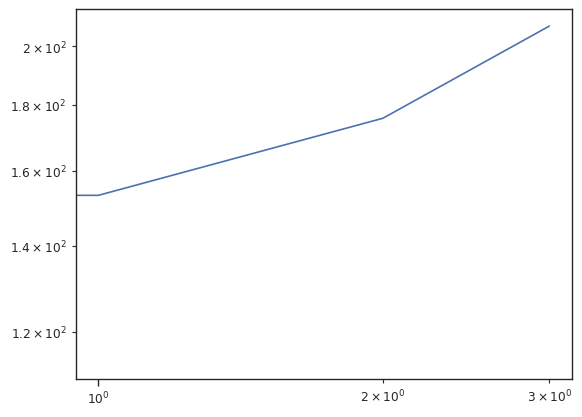

In [12]:
"""Plot MSD"""
plt.loglog(msd_avg)
plt.show()

In [13]:
print(list(msd_avg)) # in post-processing, simply average over all replicates

[113.717476, 153.21516, 175.85423, 207.36455]
